# TP05 - Machine Translation (English to French) 

# Importing  Libraries

In [1]:
import collections

import helper
import numpy as np

from keras import Input, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, LSTM
from keras.layers import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

2024-05-21 12:41:23.128176: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 12:41:23.523020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 12:41:23.523115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 12:41:23.585460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 12:41:23.711456: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 12:41:23.713203: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Dataset

In [2]:
# Load English data
english_sentences = helper.load_data('data/small_vocab_en')
# Load French data
french_sentences = helper.load_data('data/small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


### Each line in `small_vocab_en` contains an English sentence with the respective translation in each line of `small_vocab_fr`.  View the first two lines from each file. 

In [3]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


In [4]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


### preprocessing

In [5]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    tokenizer = Tokenizer(split=' ', char_level=False)
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer           # texts_to_sequences_generator(), Yields individual sequences.


# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


In [7]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    if length is None:
        length = max([len(sentence) for sentence in x])
    
    return pad_sequences(x, maxlen=length, padding='post', truncating='post')


# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


In [8]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


In [9]:
print(type(preproc_english_sentences))
print(preproc_english_sentences.shape)

<class 'numpy.ndarray'>
(137861, 15)


In [10]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1) if index_to_words[prediction]!='<PAD>'] )

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [11]:
def token_to_words(sequence, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return [index_to_words[token] for token in sequence if index_to_words[token]!='<PAD>']

In [12]:
def translate(prediction, gold_standard):
    
    translation = logits_to_text(prediction[0], french_tokenizer)
    standard = ' '.join(token_to_words(gold_standard[0][:,0],french_tokenizer)) 
    print('---- Gold standard ----')
    print(standard)
    print()
    print('---- Prediction ----')
    for w_t, w_s in zip(translation.split(), standard.split()):
        if w_t == w_s:
            print('\033[0;30;0m','{}'.format(w_t), end='')
        else:
            print('\033[0;31;47m', w_t, end='')
    print()

In [13]:
import matplotlib.pyplot as plt
def plot_learning_curves(history):
    fig, axs = plt.subplots(2, figsize=(12, 8))

    # Plot training & validation loss
    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')

    # Plot training & validation accuracy
    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot the learning curves

## Simple RNN model

In [14]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    learning_rate = 0.001
    english_input = Input(shape=input_shape[1:], name="input_layer")    # the shape is (input length x 1) as batchsize excluded
    
    # LSTM takes as input (batchsize,input_length,1) and outputs (batchsize, input_length, 64) because return-seq=True
    x = LSTM(64, return_sequences=True, activation="tanh", name="LSTM_layer")(english_input)
    preds = TimeDistributed(Dense(french_vocab_size, activation="softmax"), name="Dense_layer")(x)
    model = Model(inputs=english_input, outputs=preds, name='simple_LSTM')
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model


# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))  # reshape as 3D (batchsize, timesteps, 1) for LSTM input

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size+1)

simple_rnn_model.summary()

simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=20, validation_split=0.2)

Model: "simple_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 21, 1)]           0         
                                                                 
 LSTM_layer (LSTM)           (None, 21, 64)            16896     
                                                                 
 Dense_layer (TimeDistribut  (None, 21, 345)           22425     
 ed)                                                             
                                                                 
Total params: 39321 (153.60 KB)
Trainable params: 39321 (153.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
108/108 [==============================] - 41s 355ms/step - loss: 3.4514 - accuracy: 0.4053 - val_loss: 2.5771 - val_accuracy: 0.4635
Epoch 2/20
108/108 [==============================] - 41s 384ms/step -

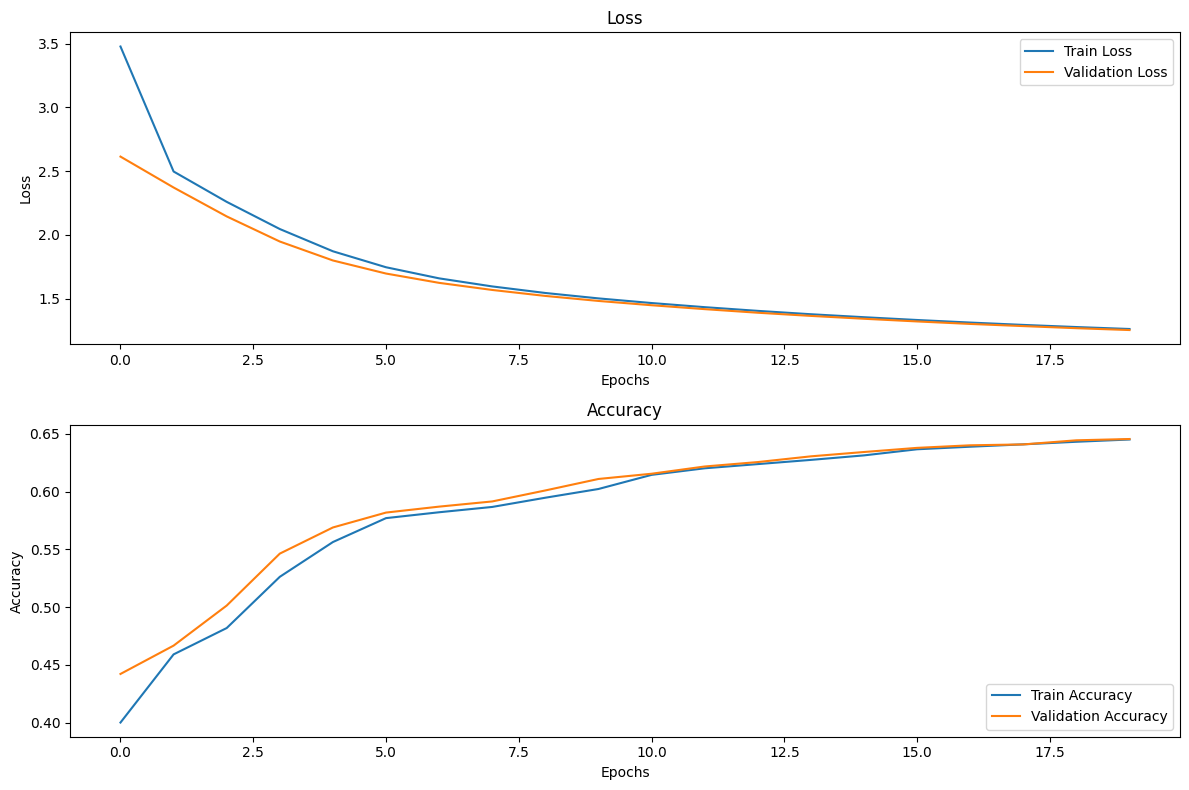

In [28]:
plot_learning_curves(simple_rnn_model.history)

In [29]:
# Print prediction(s)
print('---- Original ----')
print(' '.join(token_to_words(tmp_x[:1][0][:,0],english_tokenizer) ))
print()
translate(simple_rnn_model.predict(tmp_x[:1]), preproc_french_sentences[:1])

---- Original ----
new jersey is sometimes quiet during autumn and it is snowy in april

1/1 [==============================] - 1s 606ms/step
---- Gold standard ----
new jersey est parfois calme pendant l' automne et il est neigeux en avril

---- Prediction ----
 new jersey est parfois calme en l' et il est est en en


In [54]:

# Choose a new test index
new_test_index = 5  # Change this index to select a different sentence
test_input = tmp_x[new_test_index:new_test_index + 1]
test_output = preproc_french_sentences[new_test_index:new_test_index + 1]

# Ensure test_input has the correct shape (batch_size, sequence_length, 1)
if len(test_input.shape) == 2:
    test_input = test_input.reshape((test_input.shape[0], test_input.shape[1], 1))

# Print the original sentence
print('---- Original ----')
print(' '.join(token_to_words(test_input[0].flatten(), english_tokenizer)))
print()

# Predict the translation
prediction = simple_rnn_model.predict(test_input)

# Translate and print the prediction
translate(prediction, test_output)

---- Original ----
his favorite fruit is the orange but my favorite is the grape

1/1 [==============================] - 0s 115ms/step
---- Gold standard ----
son fruit préféré est l'orange mais mon préféré est le raisin

---- Prediction ----
 elle fruit préféré est la mais mais son préféré est la


In [58]:
# Choose a new test index
new_test_index = 345  # Change this index to select a different sentence
test_input = tmp_x[new_test_index:new_test_index + 1]
test_output = preproc_french_sentences[new_test_index:new_test_index + 1]

# Ensure test_input has the correct shape (batch_size, sequence_length, 1)
if len(test_input.shape) == 2:
    test_input = test_input.reshape((test_input.shape[0], test_input.shape[1], 1))

# Print the original sentence
print('---- Original ----')
print(' '.join(token_to_words(test_input[0].flatten(), english_tokenizer)))
print()

# Predict the translation
prediction = simple_rnn_model.predict(test_input)

# Translate and print the prediction
translate(prediction, test_output)

---- Original ----
france is busy during august and it is nice in february

1/1 [==============================] - 0s 42ms/step
---- Gold standard ----
france est occupé au mois d' août et il est agréable en février

---- Prediction ----
 la est est en mois d' août août il il est en en


## Embedding RNN Model

Model: "Embedding_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 21)]              0         
                                                                 
 Embedding_layer (Embedding  (None, 21, 256)           51200     
 )                                                               
                                                                 
 LSTM_layer (LSTM)           (None, 21, 64)            82176     
                                                                 
 Dense_layer (TimeDistribut  (None, 21, 345)           22425     
 ed)                                                             
                                                                 
Total params: 155801 (608.60 KB)
Trainable params: 155801 (608.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
1

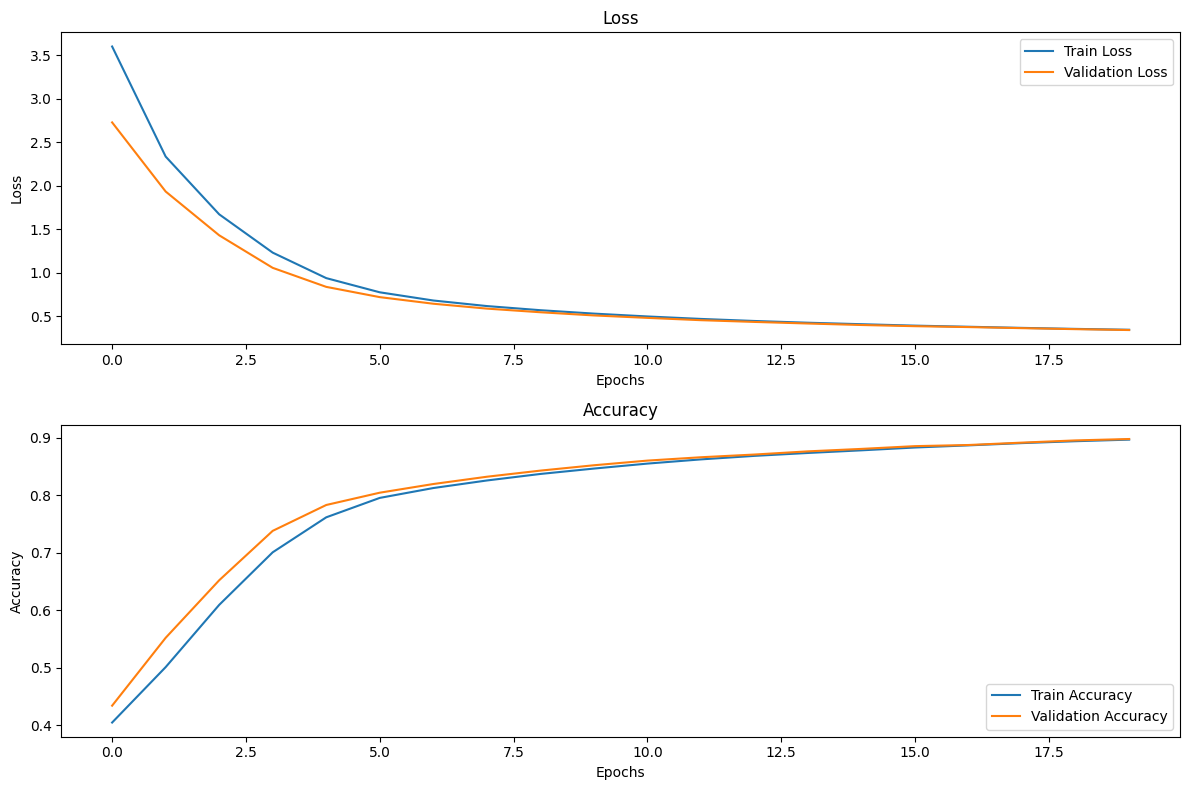

In [31]:
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    
    learning_rate = 0.001
    embedding_size = 256
    
    english_input = Input(shape=input_shape[1:], name="input_layer")   # Input shape (,seq_length)
    
    embeddings = Embedding(input_dim = english_vocab_size, output_dim = embedding_size, 
                           input_length= output_sequence_length, name="Embedding_layer")(english_input)
    
    x = LSTM(64, return_sequences=True, activation="tanh", name="LSTM_layer")(embeddings)
    
    preds = TimeDistributed(Dense(french_vocab_size, activation="softmax"), name="Dense_layer")(x)
    
    model = Model(inputs=english_input, outputs=preds, name='Embedding_LSTM')
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model


# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))    # reshaped to (batchsize, seq_length) for Embedding input

# Train the neural network
embed_rnn_model = embed_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size+1,
    french_vocab_size+1)

embed_rnn_model.summary()
    
embed_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=20, validation_split=0.2)
plot_learning_curves(embed_rnn_model.history)

In [33]:
# Print prediction(s)
print('---- Original ----')
print(' '.join(token_to_words(tmp_x[:1][0],english_tokenizer) ))
print()
translate(embed_rnn_model.predict(tmp_x[:1]), preproc_french_sentences[:1])

---- Original ----
new jersey is sometimes quiet during autumn and it is snowy in april



1/1 [==============================] - 1s 923ms/step
---- Gold standard ----
new jersey est parfois calme pendant l' automne et il est neigeux en avril

---- Prediction ----
 new jersey est parfois calme en l' et il automne est est en avril


In [61]:
# Choose a new test index
new_test_index = 345  # Change this index to select a different sentence
test_input = tmp_x[new_test_index:new_test_index + 1]
test_output = preproc_french_sentences[new_test_index:new_test_index + 1]

# Print the original sentence
print('---- Original ----')
print(' '.join(token_to_words(test_input[0], english_tokenizer)))
print()

# Predict the translation
prediction = embed_rnn_model.predict(test_input)

# Translate and print the prediction
translate(prediction, test_output)


---- Original ----
france is busy during august and it is nice in february

1/1 [==============================] - 0s 51ms/step
---- Gold standard ----
france est occupé au mois d' août et il est agréable en février

---- Prediction ----
 la france est occupé mois d' août et il est agréable en février


## bi-LSTM encoder LSTM decoder

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding_layer (Embedding  (None, 21, 256)           51200     
 )                                                               
                                                                 
 Bi_LSTM_encoder (Bidirecti  (None, 512)               1050624   
 onal)                                                           
                                                                 
 Glue (RepeatVector)         (None, 21, 512)           0         
                                                                 
 LSTM_decoder (LSTM)         (None, 21, 256)           787456    
                                                                 
 Dense (TimeDistributed)     (None, 21, 345)           88665     
                                                                 
Total params: 1977945 (7.55 MB)
Trainable params: 197794

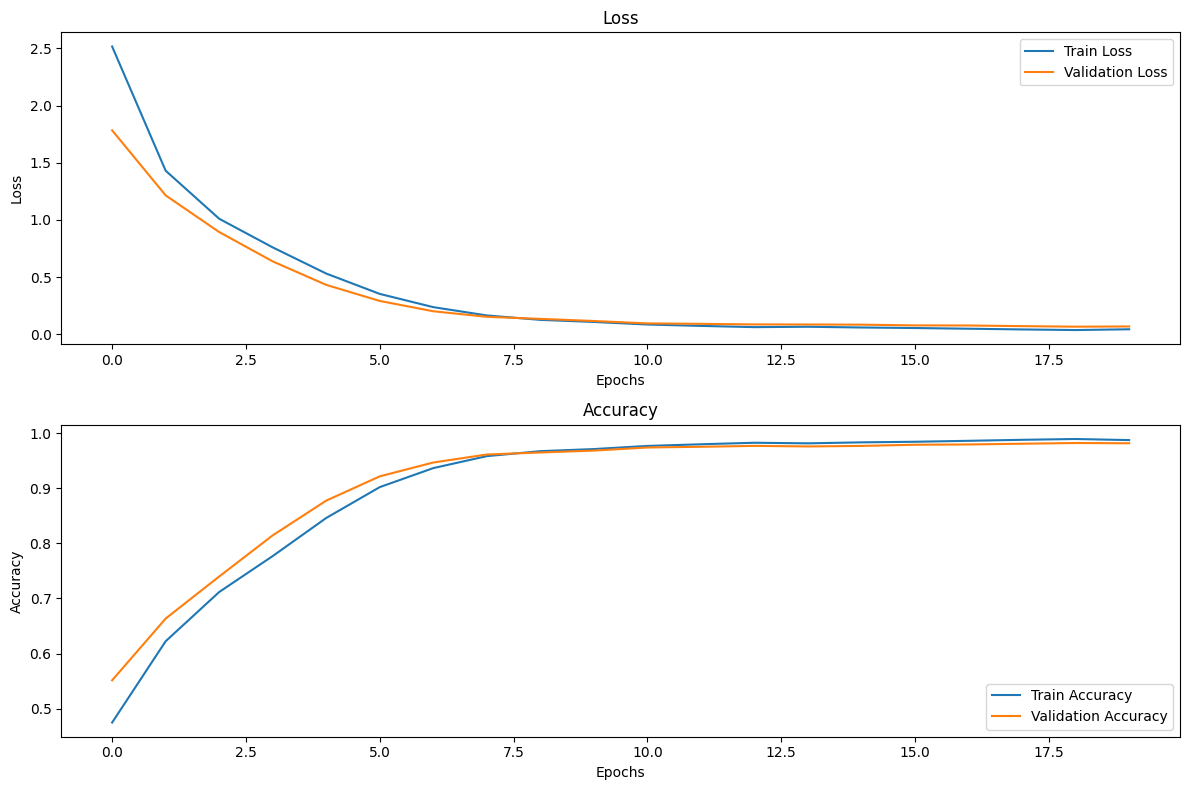

In [15]:
def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):

    
    learning_rate = 6e-3
    embedding_size = 256
    units = 256
    
    model = Sequential()
    
    ########### ENCODER ###########
    
    model.add(Embedding(input_dim = english_vocab_size, output_dim = embedding_size, 
                           input_length= input_shape[1], name="Embedding_layer"))
    model.add(Bidirectional(LSTM(units, return_sequences=False), name='Bi_LSTM_encoder'))
    
    ########### INTERMEDIARY ###########
    
    model.add(RepeatVector(output_sequence_length, name='Glue'))
    
    ########### DECODER ###########
    
    model.add(LSTM(units, return_sequences=True, name='LSTM_decoder'))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax'), name='Dense'))
    
    ########### END-TO-END MODEL ###########
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model



tmp_x = pad(preproc_english_sentences, max_french_sequence_length) # pad input sequence to output sequence length
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))    # reshape for embedding input

# Train the neural network
final_model = model_final(
                        tmp_x.shape,
                        max_french_sequence_length,
                        english_vocab_size+1,
                        french_vocab_size+1)

final_model.summary()

final_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=20, validation_split=0.2)

print('Final Model Loaded')
plot_learning_curves(final_model.history)

In [16]:
print('---- Original ----')
print(' '.join(token_to_words(tmp_x[:1][0],english_tokenizer) ))
print()
translate(final_model.predict(tmp_x[:1]), preproc_french_sentences[:1])

---- Original ----
new jersey is sometimes quiet during autumn and it is snowy in april

1/1 [==============================] - 2s 2s/step
---- Gold standard ----
new jersey est parfois calme pendant l' automne et il est neigeux en avril

---- Prediction ----
 new jersey est parfois calme pendant l' automne et il est neigeux en avril


In [16]:
final_model.save_weights('final_model')

In [17]:
final_model.save('saved_model/final_model_full')

INFO:tensorflow:Assets written to: saved_model/final_model_full/assets


INFO:tensorflow:Assets written to: saved_model/final_model_full/assets


In [17]:
from keras.models import load_model
final_model = load_model('saved_model/final_model_full')

In [22]:
def final_predictions(x, y, x_tk, y_tk, model):
    """
    Gets predictions using the final model
    :param x: Preprocessed English data
    :param y: Preprocessed French data
    :param x_tk: English tokenizer
    :param y_tk: French tokenizer
    :param model: Pre-trained model
    """
    # Align padded English sequence to the length of French padded length
    x = pad_sequences(x, maxlen=model.input_shape[1])     

    model.summary()
                                 
    ## DON'T EDIT ANYTHING BELOW THIS LINE
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'

    sentence = 'he saw a old yellow truck'
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    sentence = pad_sequences([sentence], maxlen=model.input_shape[1], padding='post')
    sentences = np.array([sentence[0], x[0]])
    predictions = model.predict(sentences)

    print('Sample 1:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
    print('Il a vu un vieux camion jaune')
    print('Sample 2:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
    print(' '.join([y_id_to_word[np.max(x)] for x in y[0]]))

# Call the function with the pre-trained model
final_predictions(preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer, final_model)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding_layer (Embedding  (None, 21, 256)           51200     
 )                                                               
                                                                 
 Bi_LSTM_encoder (Bidirecti  (None, 512)               1050624   
 onal)                                                           
                                                                 
 Glue (RepeatVector)         (None, 21, 512)           0         
                                                                 
 LSTM_decoder (LSTM)         (None, 21, 256)           787456    
                                                                 
 Dense (TimeDistributed)     (None, 21, 345)           88665     
                                                                 
Total params: 1977945 (7.55 MB)
Trainable params: 197794